# **GitHub Trend Analysis**
---

### **Aim**:

The aim of this project is to scrape data from trending topics on GitHub, analyze the top repositories for each topic, and visualize the most used tags and programming languages. By doing so, we seek to gain insights into the trends and popularity of programming languages and tags in the GitHub community.

- Scrape data from the top 20 repositories for each of the 10 trending topics on GitHub.
- Store the data with URL of topic, Topic name and description in CSV files to create a dataset for each topic.
- Perform data analysis and visualization to identify the most used tags and programming languages for each topic.
- Aggregate the data from all topics to create a dataset of the top 200 repositories.
- Visualize the most used tags and programming languages across all topics and all repos using pie charts.

### **Importing required libraries**

In [213]:
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [161]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36",
    "Accept-Language": "en-US, en;q=0.5",
}

### **Defiling URLs**

In [162]:
BASE_URL = "https://github.com"
TOPICS_URL = "https://github.com/topics"

### **Getting page source**

In [163]:
topics_webpage = requests.get(TOPICS_URL, headers=HEADERS)

#### **Success response**

In [164]:
topics_webpage

<Response [200]>

### **Parsing using BS4**

In [165]:
topics_soup = BeautifulSoup(topics_webpage.content, "html.parser")

### **Looking for all `anchor` tags**
Finding `a` tag in parsed page source having href to topic page and the urlks to repos


In [166]:
topics_anchor_tags = topics_soup.find_all(
    "a", attrs={"class": "no-underline flex-1 d-flex flex-column"}
)

### **Defining functions**

- To get repo page source
- To get number of `forks` and `stars` on repo
- To get `tags` used in description of repo
- To get the `programming languages` used in repo

In [167]:
def fetch_repo_details(repo_url):
    try:
        repo_webpage = requests.get(repo_url, headers=HEADERS)
        repo_webpage.raise_for_status()
        repo_soup = BeautifulSoup(repo_webpage.content, "html.parser")
        return repo_soup
    except requests.exceptions.RequestException as e:
        print(f"Error fetching repo details: {e}")
        return None


def parse_repo_details(repo_soup):
    repo_details = repo_soup.find(
        "ul", class_="pagehead-actions flex-shrink-0 d-none d-md-inline"
    ).find_all("li")
    parsed_repo_details = []
    for repo_detail in repo_details[-2:]:
        repo_text = repo_detail.text.replace("\n", "").strip()
        last_item = repo_text.split()[-1]
        if last_item[-1] == "k":
            numeric_part = float(last_item[:-1])
            parsed_repo_details.append(numeric_part * 1000)
        else:
            parsed_repo_details.append(float(last_item))
    return parsed_repo_details


def extract_tags(repo_soup):
    repo_tags = [
        tag.text.split("\n")[-2].strip()
        for tag in repo_soup.find_all("a", attrs={"class": "topic-tag topic-tag-link"})
    ]
    return repo_tags


def extract_languages(repo_soup):
    repo_languages = {}
    repo_languages_raw = repo_soup.find_all(
        "a",
        attrs={
            "class": "d-inline-flex flex-items-center flex-nowrap Link--secondary no-underline text-small mr-3"
        },
    )
    for language_raw in repo_languages_raw:
        language_data = language_raw.text.split()
        language_name = language_data[0]
        language_percentage = language_data[1]
        repo_languages[language_name] = language_percentage
    return repo_languages

### **Dictionary to store all data**

Format of data will be like this :
```sh
data_dict = {
    'Topic1': {
        'desc': '#Topic1\n#Description of Topic1\n#Link to Topic1 on GitHub\n',
        'repos_data': {
            'user_name': ['repo_owner1', 'repo_owner2', 'repo_owner3'],
            'repo_name': ['repo_name1', 'repo_name2', 'repo_name3'],
            'repo_url': ['repo_url1', 'repo_url2', 'repo_url3'],
            'forks': [forks1, forks2, forks3],
            'stars': [stars1, stars2, stars3],
            'tags': [
                ['tag1', 'tag2', 'tag3'],
                ['tag4', 'tag5', 'tag6'],
                ['tag7', 'tag8', 'tag9']
            ],
            'languages_used': [
                {'Language1': 'percentage1', 'Language2': 'percentage2', 'Language3': 'percentage3'},
                {'Language4': 'percentage4'},
                {'Language5': 'percentage5', 'Language6': 'percentage6'}
            ]
        }
    },
}
```

In [168]:
data : {}

### **Main program to collect all data**

In [169]:
for a_tag in topics_anchor_tags[:10]:
    topic_url = BASE_URL + a_tag["href"]
    topic_intro_data = a_tag.text.split("\n")
    topic_name = next(line for line in topic_intro_data if line.strip())
    topic_description = topic_intro_data[-3].strip()

    description = f"""# Topic name : {topic_name}
# Description : {topic_description}
# Github topic URL : {topic_url}
"""

    repos_data = {
        "user_name": [],
        "repo_name": [],
        "repo_url": [],
        "forks": [],
        "stars": [],
        "tags": [],
        "languages_used": [],
    }

    topic_soup = fetch_repo_details(topic_url)
    if topic_soup is not None:
        repos_anchor_tags = topic_soup.find_all(
            "h3", attrs={"class": "f3 color-fg-muted text-normal lh-condensed"}
        )
        for repo_link in repos_anchor_tags[:20]:
            repo_user = repo_link.find_all("a")
            user_name = repo_user[0].text.strip()
            repo_name = repo_user[1].text.strip()
            repo_url = BASE_URL + repo_user[1]["href"]
            repo_soup = fetch_repo_details(repo_url)
            if repo_soup is not None:
                repo_tags = extract_tags(repo_soup)
                repo_languages = extract_languages(repo_soup)
                parsed_repo_details = parse_repo_details(repo_soup)
                repo_forks = parsed_repo_details[0]
                repo_stars = parsed_repo_details[1]

                repos_data["user_name"].append(user_name)
                repos_data["repo_name"].append(repo_name)
                repos_data["repo_url"].append(repo_url)
                repos_data["forks"].append(repo_forks)
                repos_data["stars"].append(repo_stars)
                repos_data["tags"].append(repo_tags)
                repos_data["languages_used"].append(repo_languages)

        data[topic_name] = {"desc": description, "repos_data": repos_data}


### **Checking if we got data**

In [170]:
print("Length of data (number of topics scrapped) : ",len(data))
print('Names of topics stored as key in dictionary : ',data.keys())

Length of data (number of topics scrapped) :  10
Names of topics stored as key in dictionary :  dict_keys(['3D', 'Ajax', 'Algorithm', 'Amp', 'Android', 'Angular', 'Ansible', 'API', 'Arduino', 'ASP.NET'])


### **Making `data` folder to store all topics CSV**

In [171]:
if not os.path.exists('data'):
    os.makedirs('data')

### **Cheking for data**
- result : `empty`

In [172]:
!ls

data
github-top-repos-scrapper-notebook.ipynb


In [173]:
os.listdir('data/')

[]

### **Saving each topic as csv file having data of it's repos**

In [174]:
for key, value in data.items():
    desc = value['desc']
    repos_data = value['repos_data']
    
    df = pd.DataFrame(repos_data)
    
    csv_file_name = f'data/{key}.csv'
    
    df.to_csv(csv_file_name, index=False)
    
    with open(csv_file_name, 'r+') as file:
        content = file.read()
        file.seek(0, 0)
        file.write(desc + content)

    print(f"{key}.csv has been created and saved in the 'data' folder.")

3D.csv has been created and saved in the 'data' folder.
Ajax.csv has been created and saved in the 'data' folder.
Algorithm.csv has been created and saved in the 'data' folder.
Amp.csv has been created and saved in the 'data' folder.
Android.csv has been created and saved in the 'data' folder.
Angular.csv has been created and saved in the 'data' folder.
Ansible.csv has been created and saved in the 'data' folder.
API.csv has been created and saved in the 'data' folder.
Arduino.csv has been created and saved in the 'data' folder.
ASP.NET.csv has been created and saved in the 'data' folder.


### **Data write successful**

In [175]:
os.listdir('data/')

['API.csv',
 'ASP.NET.csv',
 'Arduino.csv',
 '3D.csv',
 'Amp.csv',
 'Ansible.csv',
 'Algorithm.csv',
 'Android.csv',
 'Angular.csv',
 'Ajax.csv']

## **Visualization**

We'll look for the most used tags and programming languages used in top topics through pie charts

### **Defining functions**
- To read data from directory
- Extract tags and languages used in repos from dataset
- Create Pie chat for both top 10 languages and tags used

In [214]:
def read_data_from_csv(csv_file):
    csv_path = os.path.join("data", csv_file)
    data = pd.read_csv(csv_path, skiprows=3)
    return data

def extract_tags_and_languages(data):
    all_tags = []
    languages_count = {}

    for tags_str, lang_dict in zip(data["tags"], data["languages_used"]):
        tags_list = ast.literal_eval(tags_str)
        all_tags.extend(tags_list)

        languages = ast.literal_eval(lang_dict)
        for lang, percent in languages.items():
            if lang in languages_count:
                languages_count[lang] += 1
            else:
                languages_count[lang] = 1

    return all_tags, languages_count

def create_combined_pie_chart(topic_name, tags_data, languages_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    tags_counts = list(tags_data.values())
    tags_labels = list(tags_data.keys())
    
    languages_counts = list(languages_data.values())
    languages_labels = list(languages_data.keys())

    axes[0].pie(tags_counts, labels=tags_labels, autopct="%1.1f%%")
    axes[0].set_title("Top 10 Most Used Tags")
    
    axes[1].pie(languages_counts, labels=languages_labels, autopct="%1.1f%%")
    axes[1].set_title("Top 10 Most Common Programming Languages")

    plt.suptitle(f"Stats for {topic_name}")
    plt.show()


In [215]:
data_folder = "data"
topic_data = {}
combined_tags = []
combined_languages = {}

### **Top 10 tags and lanuages from all 200 repos**

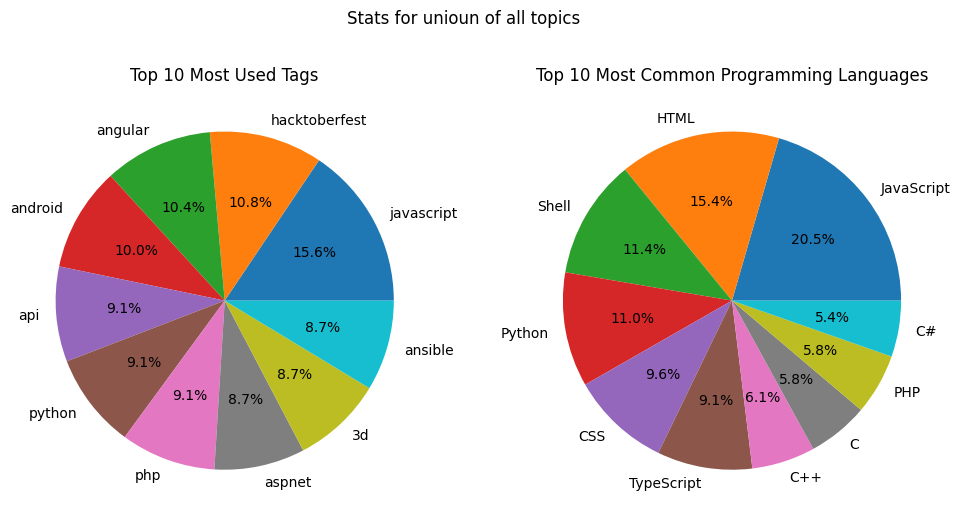

In [216]:
for csv_file in os.listdir(data_folder):
    if csv_file.endswith(".csv"):
        topic_name = os.path.splitext(csv_file)[0]
        data = read_data_from_csv(csv_file)
        all_tags, languages_count = extract_tags_and_languages(data)
        top_tags = dict(pd.Series(all_tags).value_counts()[:10])
        top_languages = dict(sorted(languages_count.items(), key=lambda x: x[1], reverse=True)[:10])
        topic_data[topic_name] = {"tags": top_tags, "languages": top_languages}
        
        combined_tags.extend(all_tags)
        for lang, count in languages_count.items():
            combined_languages[lang] = combined_languages.get(lang, 0) + count

combined_tags = dict(pd.Series(combined_tags).value_counts()[:10])
combined_languages = dict(sorted(combined_languages.items(), key=lambda x: x[1], reverse=True)[:10])

create_combined_pie_chart("unioun of all topics", combined_tags, combined_languages)

### **Top 10 tags and languages used in each topic**

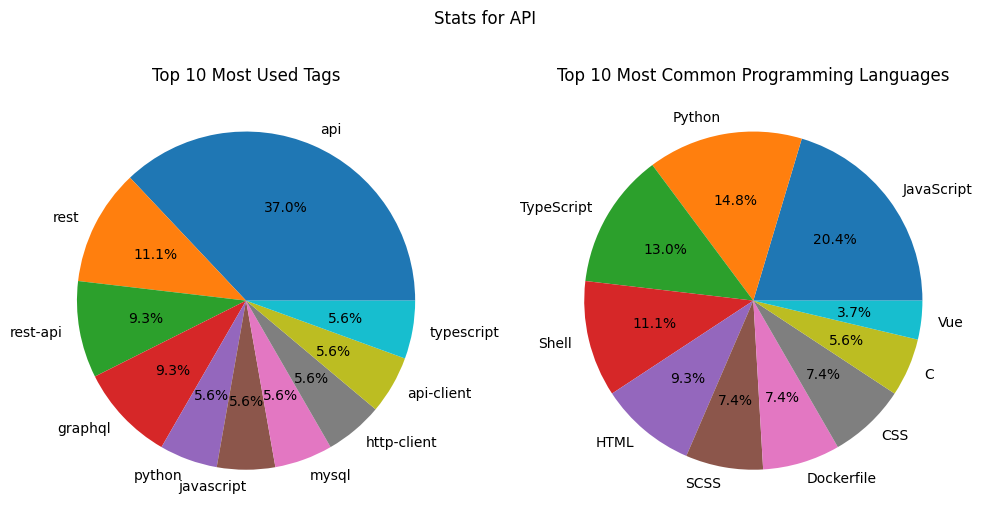

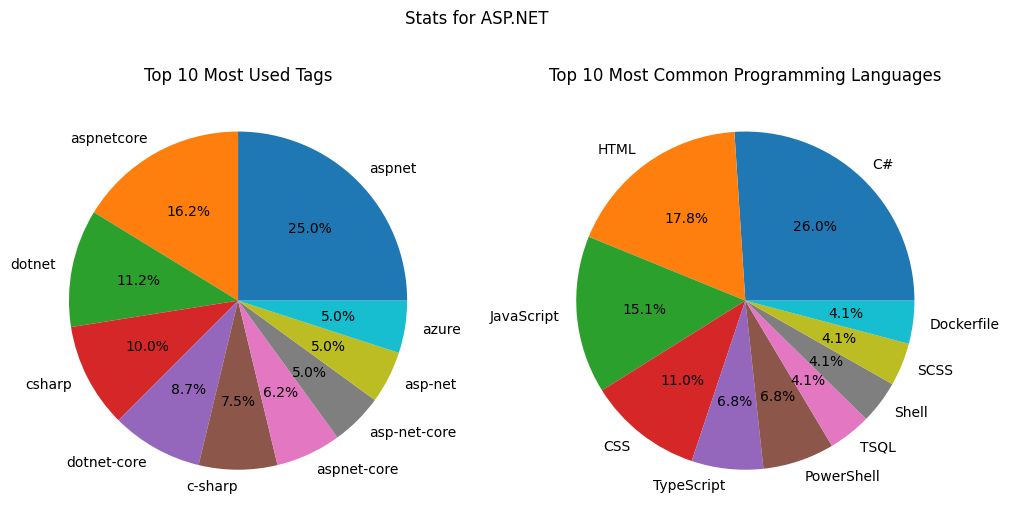

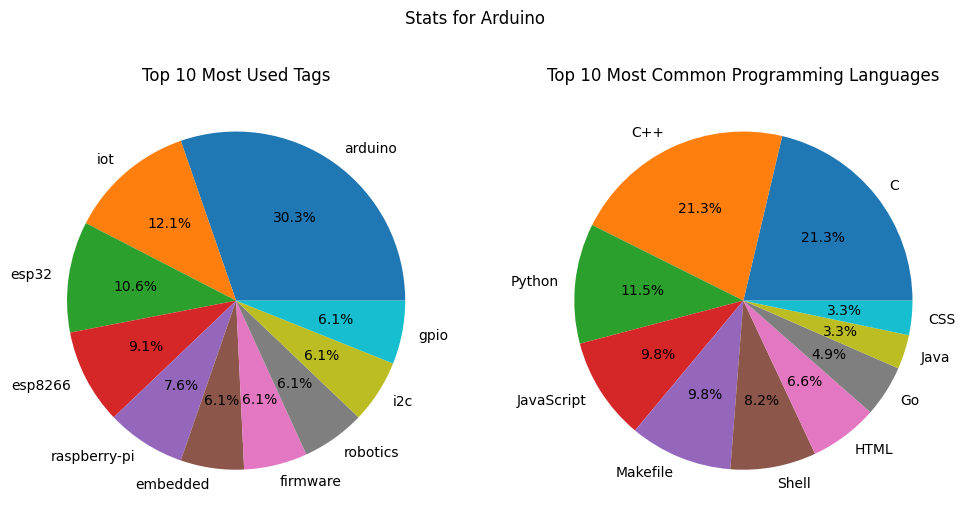

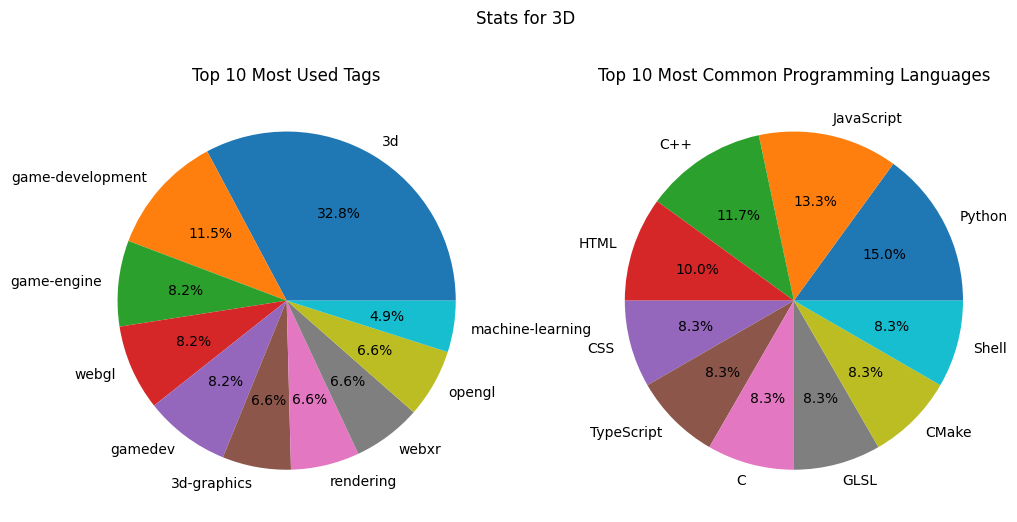

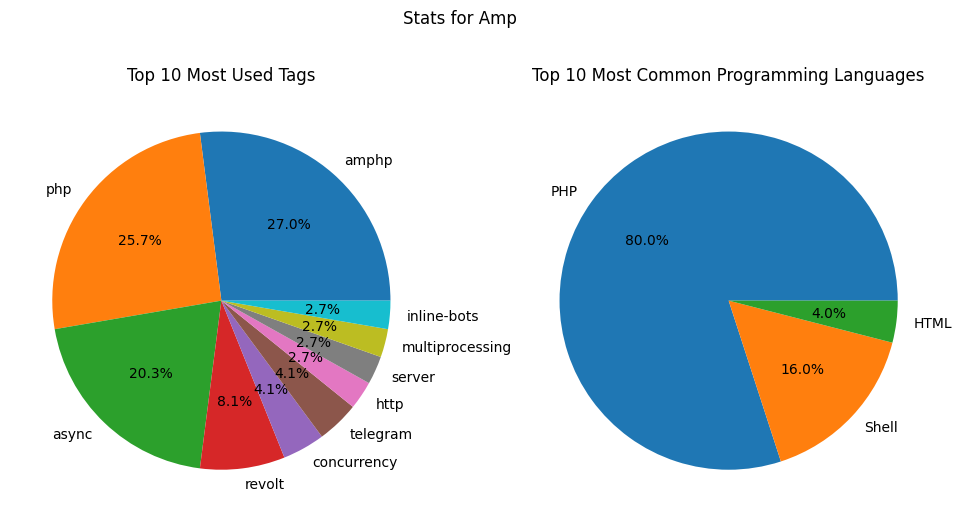

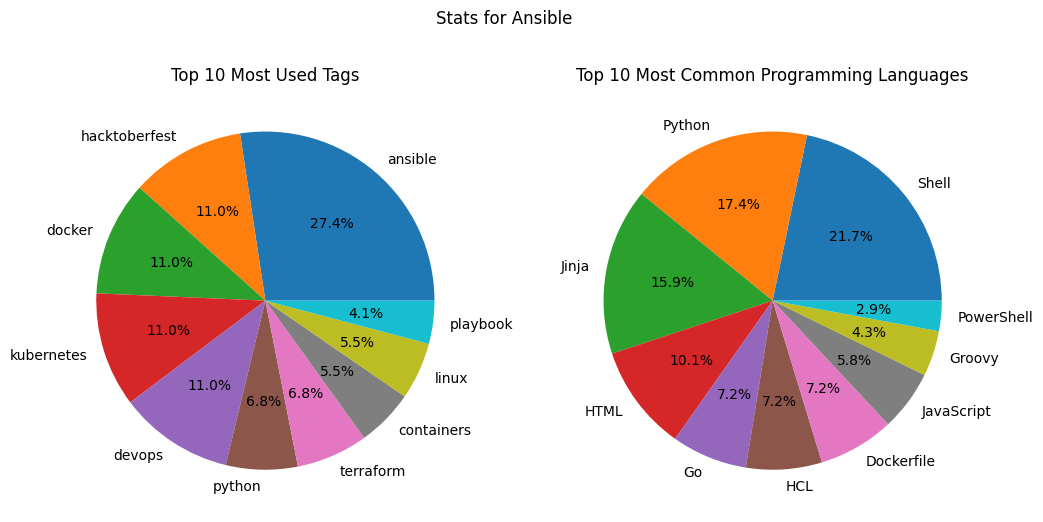

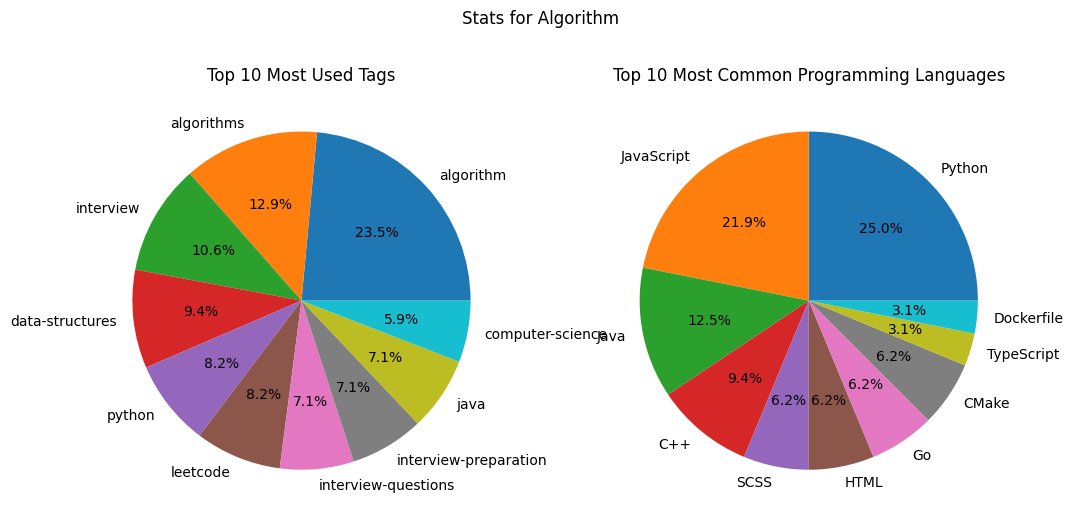

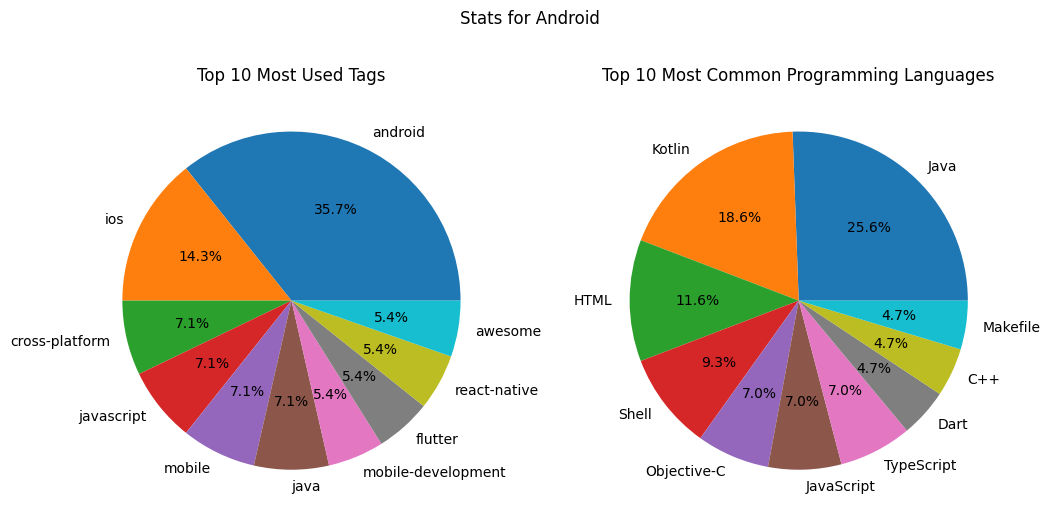

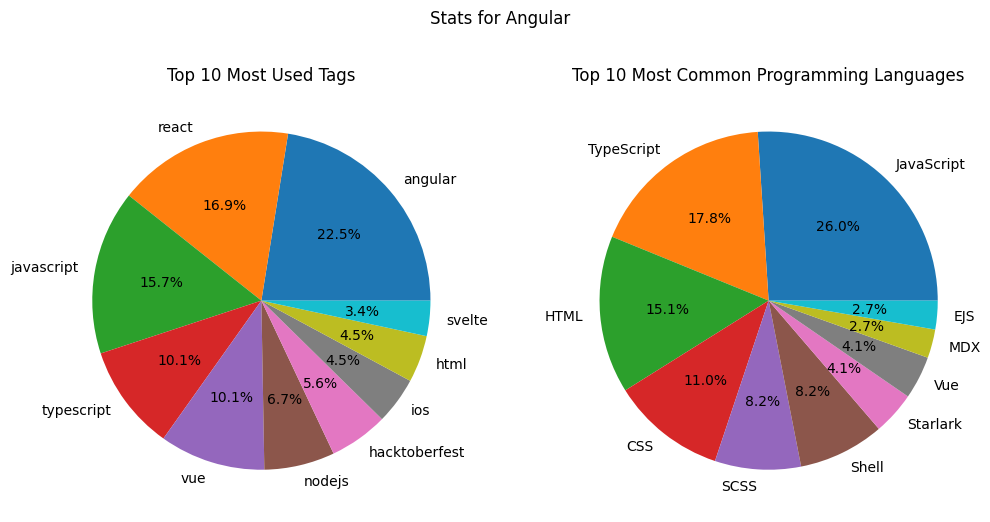

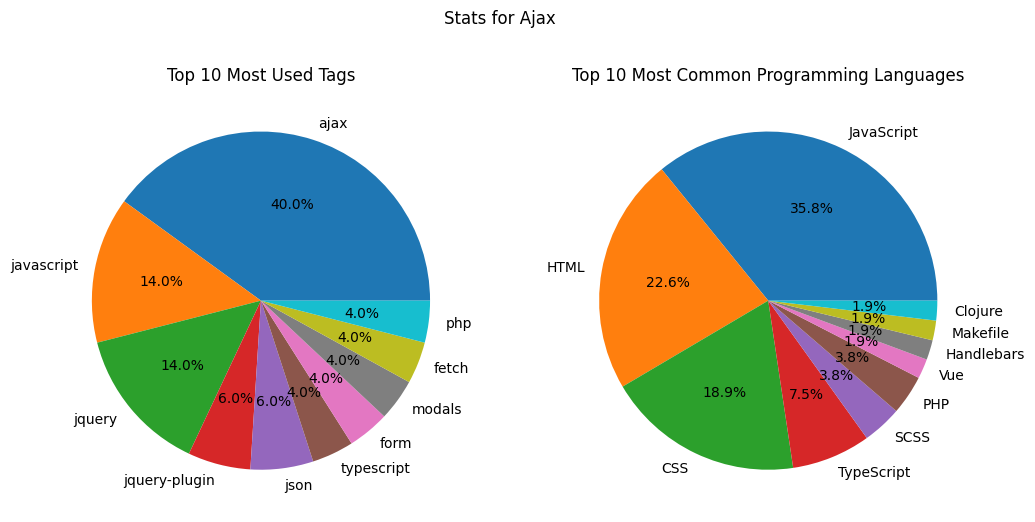

In [217]:
for csv_file in os.listdir(data_folder):
    if csv_file.endswith(".csv"):
        topic_name = os.path.splitext(csv_file)[0]
        data = read_data_from_csv(csv_file)
        all_tags, languages_count = extract_tags_and_languages(data)
        top_tags = dict(pd.Series(all_tags).value_counts()[:10])
        top_languages = dict(sorted(languages_count.items(), key=lambda x: x[1], reverse=True)[:10])
        topic_data[topic_name] = {"tags": top_tags, "languages": top_languages}

for topic_name, topic_info in topic_data.items():
    create_combined_pie_chart(topic_name, topic_info["tags"], topic_info["languages"])

### **Results**:

We can see that javascript, shell and python are most used programming languages in the top 200 reposisitry and in most used tags in description of repos we have javascript, hacktoberfest, shell and android.

---
### **Conclusion**

In this project, we have achieved the following results:

- Successfully scraped data from the top 20 repositories for each of the 10 trending topics on GitHub.
- Created individual CSV datasets for each topic containing repository information.
- Analyzed and visualized the top 10 most used tags and programming languages for each topic.
- Compiled a dataset of the top 200 repositories by aggregating data from all topics.
- Visualized the most used tags and programming languages across all 200 repositories.

Thank you for taking the time to explore this notebook! If you have any questions or suggestions for improvement, please feel free to reach out.

**Happy coding!**